# 通道

在生物神经元中，离子通道控制着钠、钾、钙等离子的通透性，是神经信号发生与传递的基础。不同类型的通道具有各自的动力学特性，并对膜电位的变化产生影响。

`braincell` 的通道建模具备以下几个显著优势：
- 接口统一：无论是线性通道还是复杂 Markov 模型，均可统一表示和集成。
- 灵活性强：支持多种电流类型，同时支持用户自定义建模。
- 兼容 `brainstate` 的自动微分系统：每个状态变量都能被精确地自动求导，支持高效训练与优化。
- 可拓展性高：通过继承与组合机制，通道模型可以轻松构建子类，实现参数修改与拓展。

`braincell` 具有高度的灵活性。对于 `Channel` ，`braincell` 支持两种用法，一种是自定义新的离子通道，另一种是使用现有的通道。

## 现有通道调用

我们先来讲解如何使用现有通道。

我们根据[通道功能的不同](https://elifesciences.org/articles/22152)，将 `Channel` 分为以下几个基类：
- `Calcium Channels`：钙离子通道
- `Potassium Channels`：钾离子通道
- `Sodium Channels`：钠离子通道
- `Potassium Calcium Channels`：钙依赖性钾通道
- `Hyperpolarization-Activated Channels`：超极化激活通道
- `Leakage Channels`：漏电通道

`braincell` 已经在每种基类中内置好了许多的具体通道，你可以任意使用。
如果想了解更多的内置的通道，你可以通过查阅 [离子通道合集](../apis/braincell.channel.rst) 来学习使用。

当在实际对神经元进行建模时，不管是现有的通道，还是自定义的通道，我们都需要进行调用。
当然，这个调用是相当简单的。但我们同样要注意一些调用的规范。

下面我们来看对 `HTC` 神经元建模的例子：

In [1]:
import brainstate
import brainunit as u
import matplotlib.pyplot as plt

import braincell

In [2]:
class HTC(braincell.SingleCompartment):
    def __init__(
        self,
        size,
        gKL=0.01 * (u.mS / u.cm ** 2),
        V_initializer=brainstate.init.Constant(-65. * u.mV),
        solver: str = 'ind_exp_euler'
    ):
        super().__init__(size, V_initializer=V_initializer, V_th=20. * u.mV, solver=solver)

        self.area = 1e-3 / (2.9e-4 * u.cm ** 2)

        self.na = braincell.ion.SodiumFixed(size, E=50. * u.mV)
        self.na.add(INa=braincell.channel.INa_Ba2002(size, V_sh=-30 * u.mV))

        self.k = braincell.ion.PotassiumFixed(size, E=-90. * u.mV)
        self.k.add(IKL=braincell.channel.IK_Leak(size, g_max=gKL))
        self.k.add(IDR=braincell.channel.IKDR_Ba2002(size, V_sh=-30. * u.mV, phi=0.25))

        self.ca = braincell.ion.CalciumDetailed(
            size,
            C_rest=5e-5 * u.mM,
            tau=10. * u.ms,
            d=0.5 * u.um
        )
        self.ca.add(ICaL=braincell.channel.ICaL_IS2008(size, g_max=0.5 * (u.mS / u.cm ** 2)))
        self.ca.add(ICaN=braincell.channel.ICaN_IS2008(size, g_max=0.5 * (u.mS / u.cm ** 2)))
        self.ca.add(ICaT=braincell.channel.ICaT_HM1992(size, g_max=2.1 * (u.mS / u.cm ** 2)))
        self.ca.add(ICaHT=braincell.channel.ICaHT_HM1992(size, g_max=3.0 * (u.mS / u.cm ** 2)))

        self.kca = braincell.MixIons(self.k, self.ca)
        self.kca.add(IAHP=braincell.channel.IAHP_De1994(size, g_max=0.3 * (u.mS / u.cm ** 2)))

        self.Ih = braincell.channel.Ih_HM1992(size, g_max=0.01 * (u.mS / u.cm ** 2), E=-43 * u.mV)
        self.IL = braincell.channel.IL(size, g_max=0.0075 * (u.mS / u.cm ** 2), E=-70 * u.mV)

通过这个 `HTC` 神经元的例子可以很清晰的看出，在实际建模中，我们只需简单将相关的通道传入即可。

但值得注意的是，本例中的通道都已经显式定义在 `braincell` 的代码仓库中。
若想使用其他通道，你可以将你的自定义通道定义于`braincell` 代码仓库中，或者使用 `import` 将你自定义的通道引入。

### `root_type` 的使用

使用每一个通道时，我们都需要注意 `root_type` 的使用。一般来说，钙离子通道依赖于 `Calcium` 离子，钾离子通道依赖于 `Potassium` 离子，钠离子通道依赖于 `Sodium` 离子。

In [3]:
braincell.channel.CalciumChannel.root_type

braincell.ion.Calcium

In [4]:
braincell.channel.PotassiumChannel.root_type

braincell.ion.Potassium

In [5]:
braincell.channel.SodiumChannel.root_type

braincell.ion.Sodium

钙依赖性钾通道同时依赖于 `Potassium` 和 `Calcium` 离子。

In [6]:
braincell.channel.IAHP_De1994.root_type

typing.JointTypes[braincell.ion.Potassium, braincell.ion.Calcium]

对于一些特殊的通道，如 `IL`，它们并不依赖于任何离子类型，因此其 `root_type` 为细胞。

In [7]:
braincell.channel.IL.root_type

braincell.HHTypedNeuron

### 添加离子通道

在进行单细胞建模时，我们通常需要将离子通道添加到离子中。如果不注意 `root_type` 的使用，可能会导致离子通道无法正确工作。比如，钠离子通道只能添加到钠离子中，钾离子通道只能添加到钾离子中。如果你尝试将钠离子通道添加到钾离子中，或者将钾离子通道添加到钙离子中，都会导致错误。


In [8]:
na = braincell.ion.SodiumFixed(1)

In [9]:
na.add(ina=braincell.channel.INa_HH1952(1))

In [10]:
try:
    na.add(ik=braincell.channel.IK_HH1952(1))
except Exception as e:
    print(e)

Type does not match. IK_HH1952(
  size=(1,),
  name=None,
  g_max=10. * msiemens / cmeter2,
  phi=1.0,
  V_sh=-45. * mvolt
) requires a root with type of <class 'braincell.ion.Potassium'>, but the root now is <class 'braincell.ion.SodiumFixed'>.


### 模拟离子通道

我们也可以直接模拟离子通道，而不需要将其添加到离子中。这样可以更灵活地使用离子通道。然而，模拟离子通道时，我们需要添加我们需要的神经元膜电位和离子浓度等信息。我们以钙离子通道为例。

In [11]:
ca = braincell.ion.CalciumFixed(1).pack_info()
V = -65 * u.mV

# 要进行模拟的钙离子通道
can = braincell.channel.ICaL_IS2008(1)
can.init_state(V, ca)

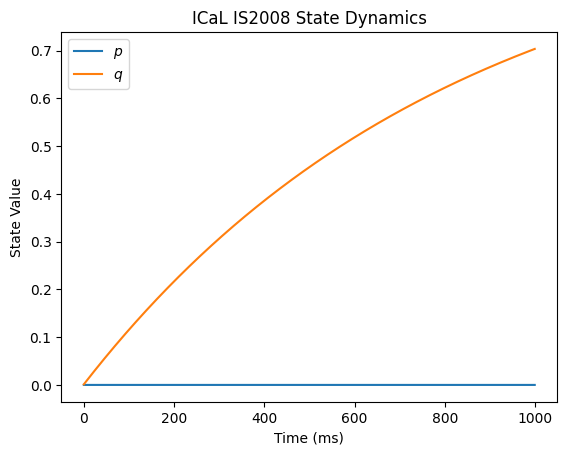

In [12]:
def run_can(i):
    dt = 0.1 * u.ms
    t = i * dt
    with brainstate.environ.context(i=i, t=t, dt=dt):
        braincell.ind_exp_euler_step(can, t, dt, V, ca)
    return can.p.value, can.q.value


indices = u.math.arange(1000)
ps, qs = brainstate.transform.for_loop(run_can, indices)

plt.plot(indices, ps, label='$p$')
plt.plot(indices, qs, label='$q$')
plt.xlabel('Time (ms)')
plt.ylabel('State Value')
plt.title('ICaL IS2008 State Dynamics')
plt.legend()
plt.show()


## 自定义通道建模

现在我们来讲解如何使用自定义通道。

在 `braincell` 中，我们使用 `IonChannel` 类作为通道建模的基础类。所有具体的通道模型都应继承自该类。

`IonChannel` 提供了以下接口，用于支持仿真过程中的关键操作：
- `current`：计算通道产生的离子电流。
- `init_state`：初始化通道的状态变量。
- `reset_state`：重置通道状态。
- `compute_derivative`：计算通道内部状态变量的导数，用于积分器的积分。
- `pre_integral` 和 `post_integral`：积分前/后的操作，一般不使用。

`compute_derivative`, `pre_integral` 和 `post_integral`是积分的核心接口，通常需要在具体通道中实现，详细介绍可以参考 [微分系统](../advanced_tutorial/differential_equation-zh.ipynb) 部分。这些方法都能与 `braincell` 的微分系统集成。在实际自定义离子通道的时候，我们需要设置好通道需要的相关接口，以完成特定的功能需求。

`IonChannel` 包含了 `Ion` 和`Channel`。因此，我们定义了一个直接继承自 `IonChannel` 的基类 `Channel` 来进行封装。
当然，在语义上，我们更建议你用 `Channel` 来开发实际通道模型。

在完成了对 `Channel` 这个基类的建模之后，是时候对不同的具体通道进行建模了。
从实际应用上说，我们希望 `Channel` 的子类应该实现特定的方法，以定义特定通道类型的行为。

下面我们正式来讲解对于不同的目标建模通道如何完成自定义。

### 基类通道建模

首先，如果要对一个全新的通道进行建模，我们要先判断目标通道是否可被分类至目前已有的基类通道中。

前面讲到， `braincell` 将 `Channel` 分为以下几类：
- `Calcium Channels`：钙离子通道
- `Potassium Channels`：钾离子通道
- `Sodium Channels`：钠离子通道
- `Potassium Calcium Channels`：钙依赖性钾通道
- `Hyperpolarization-Activated Channels`：超极化激活通道
- `Leakage Channels`：漏电通道

以上这些通道都是直接继承自 `Channel` 的基类。如果你想自定义的通道属于这些类别，请直接查阅后面的子类通道建模教学与具体通道建模教学。
如果你想自定义的通道并不属于我们为你提供的这些基类，我们将以对 `Calcium Channels` 的建模为例，讲解如何对一个离子通道基类进行建模。

在 `braincell.channel` 模块中，所有离子通道都最终继承自统一的抽象基类 `Channel`。
该类定义了所有通道必须实现的最小接口，为通用建模提供统一框架。

在实际建模中，我们通常需要为不同离子类型定义各自的基类。
这些类型专属的中间层基类可以封装通道类型、输入参数、接口结构，提供更清晰、更易维护的建模层级。

我们来看下面这个 `Calcium Channels` 建模的例子：

In [13]:
class CalciumChannel(braincell.Channel):
    # 指定该通道作用的离子类型
    root_type = braincell.ion.Calcium

    def pre_integral(self, V, Ca: braincell.IonInfo):
        pass

    def post_integral(self, V, Ca: braincell.IonInfo):
        pass

    def compute_derivative(self, V, Ca: braincell.IonInfo):
        pass

    def current(self, V, Ca: braincell.IonInfo):
        raise NotImplementedError

    def init_state(self, V, Ca: braincell.IonInfo, batch_size=None):
        pass

    def reset_state(self, V, Ca: braincell.IonInfo, batch_size=None):
        pass

以上代码就轻松完成了对 `CalciumChannel` 的建模。

观察代码，其中最重要的就是定义 `root_type = Calcium` 。
这是 `CalciumChannel` 的核心，它告诉 `braincell` ：
这个通道只作用于 `Calcium` ，同时传入的参数 `Ca` 一定是 `IonInfo` 类型，用于表示钙离子的状态。
这使得你在实现 `current`, `compute_derivative` 等接口时可以获取到该离子的信息。

一旦你定义好了 `CalciumChannel`，后续所有具体的钙通道子类都可以继承它：
此时你不再需要关心 `IonInfo` 的来源，`braincell` 会自动把 `Calcium` 类型的离子传给你。

同时，在对新的基类通道建模的时候，要注意对接口的定义，这些接口可以参照 `Channel` 中定义的接口，也可以根据实际需求去进行自定义。

通过构造 `CalciumChannel` 这样的类型专属通道基类，我们可以：
- 明确模型适用的离子类型。
- 统一接口。
- 简化下游模型编写。
- 提高代码复用性与可维护性。

这种设计也适用于钠通道 `SodiumChannel` 、钾通道 `PotassiumChannel` 等其他离子通道，推荐作为编写自定义通道模型的标准做法。

### 具体通道建模

以下我们以 `ICaT_HP1992` 的代码为示例，来展示如何自定义离子通道模型。

 `ICaT_HP1992` 离子通道是一个钙通道模型，参考了 Huguenard & Prince 在 1992 年提出的钙通道模型：[<A novel T-type current underlies prolonged Ca(2+)-dependent burst firing in GABAergic neurons of rat thalamic reticular nucleus>](https://pubmed.ncbi.nlm.nih.gov/1403085/)。

对其建模只需要参考具体公式，并将公式用代码表达即可：

我们先定义参数：

- $p$ 和 $q$ 是两个激活和失活门控变量
- $\phi_p = 5^{\frac{T-24}{10}}$ 和 $\phi_q = 3^{\frac{T-24}{10}}$ 是温度依赖因子（$T$ 为摄氏度温度）
- $E_{Ca}$ 是钙离子通道的反转电位
- $p_{\infty}$, $q_{\infty}$ 是 $p, q$ 的稳态激活/失活函数（电压依赖）
- $\tau_p, \tau_q$ 是电压依赖的时间常数
- $\phi_p, \phi_q$ 是温度修正因子
- $g_{max}$ 是最大电导
- $V$ 是膜电位，$E_{Ca}$ 是钙离子反转电位
- $V_{sh}$ 是膜电位偏移量


In [14]:
class ICaT_HP1992(CalciumChannel):
    root_type = braincell.ion.Calcium

    def __init__(
        self,
        size: brainstate.typing.Size,
        T: brainstate.typing.ArrayLike = u.celsius2kelvin(36.),
        T_base_p: brainstate.typing.ArrayLike = 5.,
        T_base_q: brainstate.typing.ArrayLike = 3.,
        g_max=1.75 * (u.mS / u.cm ** 2),
        V_sh=-3. * u.mV,
        phi_p=None,
        phi_q=None,
    ):
        super().__init__(size)

        T = u.kelvin2celsius(T)
        phi_p = T_base_p ** ((T - 24) / 10) if phi_p is None else phi_p
        phi_q = T_base_q ** ((T - 24) / 10) if phi_q is None else phi_q
        # parameters
        self.phi_p = brainstate.init.param(phi_p, self.varshape, allow_none=False)
        self.phi_q = brainstate.init.param(phi_q, self.varshape, allow_none=False)
        self.g_max = brainstate.init.param(g_max, self.varshape, allow_none=False)
        self.T = brainstate.init.param(T, self.varshape, allow_none=False)
        self.T_base_p = brainstate.init.param(T_base_p, self.varshape, allow_none=False)
        self.T_base_q = brainstate.init.param(T_base_q, self.varshape, allow_none=False)
        self.V_sh = brainstate.init.param(V_sh, self.varshape, allow_none=False)

然后对$p_{\infty}$有

$$
p_{\infty} = \frac{1}{1 + \exp[-(V + 52 - V_{sh}) / 7.4]}
$$

In [15]:
    def f_p_inf(self, V):
        V = (V - self.V_sh).to_decimal(u.mV)
        return 1. / (1. + u.math.exp(-(V + 52.) / 7.4))

对$\tau_p$有：

$$\tau_p = 3 + \frac{1}{\exp[(V + 27 - V_{sh}) / 10] + \exp[-(V + 102 - V_{sh}) / 15]}$$

In [16]:
    def f_p_tau(self, V):
        V = (V - self.V_sh).to_decimal(u.mV)
        return 3. + 1. / (u.math.exp((V + 27.) / 10.) +
                          u.math.exp(-(V + 102.) / 15.))

对$q_{\infty}$有：

$$q_{\infty} = \frac{1}{1 + \exp[(V + 80 - V_{sh}) / 5]}$$

In [17]:
    def f_q_inf(self, V):
        V = (V - self.V_sh).to_decimal(u.mV)
        return 1. / (1. + u.math.exp((V + 80.) / 5.))

对$\tau_q$则有：

$$\tau_q = 85 + \frac{1}{\exp[(V + 48 - V_{sh}) / 4] + \exp[-(V + 407 - V_{sh}) / 50]}$$

In [18]:
    def f_q_tau(self, V):
        V = (V - self.V_sh).to_decimal(u.mV)
        return 85. + 1. / (u.math.exp((V + 48.) / 4.) + u.math.exp(-(V + 407.) / 50.))

同时要对 `state` 进行设定：

In [19]:
    def init_state(self, V, Ca: braincell.IonInfo, batch_size: int = None):
        self.p = braincell.DiffEqState(brainstate.init.param(u.math.zeros, self.varshape, batch_size))
        self.q = braincell.DiffEqState(brainstate.init.param(u.math.zeros, self.varshape, batch_size))

In [20]:
    def reset_state(self, V, Ca, batch_size=None):
        self.p.value = self.f_p_inf(V)
        self.q.value = self.f_q_inf(V)
        if batch_size is not None:
            assert self.p.value.shape[0] == batch_size
            assert self.q.value.shape[0] == batch_size

对于$\frac{dp}{dt}$和$\frac{dq}{dt}$则有：

$$\frac{dp}{dt} = \frac{\phi_p \cdot (p_{\infty} - p)}{\tau_p}$$

$$\frac{dq}{dt} = \frac{\phi_q \cdot (q_{\infty} - q)}{\tau_q}$$

In [21]:
    def compute_derivative(self, V, Ca: braincell.IonInfo):
        self.p.derivative = self.phi_p * (self.f_p_inf(V) - self.p.value) / self.f_p_tau(V) / u.ms
        self.q.derivative = self.phi_q * (self.f_q_inf(V) - self.q.value) / self.f_q_tau(V) / u.ms

最后，对于整体的$I_{CaT}$有：

$$I_{CaT} = g_{max} \cdot p^2 \cdot q \cdot (V - E_{Ca})$$

In [22]:
    def current(self, V, Ca: braincell.IonInfo):
        return self.g_max * self.p.value * self.p.value * self.q.value * (Ca.E - V)

至此，我们就完成了对 `ICaT_HP1992` 的建模。

在 `braincell` 中，我们通常用 `__init__` 来构造函数，并且在初始化类时接受相关参数，如 `size` 、 `phi_p`、`phi_q` 等。

并且，我们要注意使用 `brainstate.init.param` 把 `phi_p`、 `phi_q`、 `g_max` 注册成可变参数，这样才能支持后续的自动微分、更新和批量计算。

同时，设定接口时要根据实际情况或具体参考公式，如接口 `compute_derivative` 就参考了具体公式：

通过以上建模，可以使子类通道具有以下功能：
- 封装了 $p^2 q$ 形式的钙电流动力学框架。
- 管理状态变量 $p, q$ 的初始化、更新、计算电流。
- 保留具体的参数由子类定义。
- 支持批量计算和参数可微分。

这种建模框架适用于在实际建模时遇到的不同需求，泛用性强，灵活性高。




## 现有通道实例

在讲解完如何调用现有通道和自定义通道之后，我们来介绍一些具体的通道实例。无论是使用现有的内置通道，还是建立新的自定义通道，这些实例都是很好的参考，能在你对通道建模有疑问的时候提供参考。以下的通道实例提供了具体的通道电生理特性与建模思路。

### Calcium Channels

#### 电生理特性

钙离子通道是一类高度重要的膜通道，负责调节钙离子在细胞膜上的跨膜流动。钙离子在神经系统中不仅参与膜电位的变化，还在以下过程中扮演着关键角色：
- 动作电位的产生与延续：某些神经元类型依赖钙通道触发或维持放电节律。
- 突触传递：钙离子内流触发神经递质释放。
- 细胞内信号转导：钙离子可调控蛋白激酶活性、基因表达、酶促反应等。
- 钙依赖通道调控：许多钾通道或混合通道也受到钙浓度的调节。

钙通道通常具有缓慢激活、钙依赖失活、以及高选择性等特点。它们常常与钙泵和缓冲蛋白共同作用，以维持钙稳态。

![钙离子通道](../_static/calciumchannel.png)

#### 建模实现

在 `braincell` 中，钙通道的建模通过继承 `CalciumChannel` 来实现，而 `CalciumChannel` 本身又继承自 `Channel`，属于 `IonChannel` 的一部分。

因此，在实际应用中我们需要实现相应的接口，如 `current(V, Ca)`、`compute_derivative(V, Ca)`等。
其中，`Ca` 参数是一个 `IonInfo` 类型，包含通道局部的钙浓度信息。而关于 `IonInfo` 的信息，我们会在 `Ion` 部分进行详细介绍。

通过这些接口，我们可以构建具有复杂动力学特性的钙通道，比如电压和钙浓度双重调控、钙依赖失活、稳态激活门控等。

在了解了基本的建模后，我们来看一个实际例子： `ICaN_IS2008`。

这是由 Inoue & Strowbridge 在 2008 年提出的一个钙激活的非选择性阳离子通道模型。
`braincell` 对离子通道有一套固定的命名规则，格式为 `通道类型_文献标识`。`braincell` 中大部分通道都是采用这种形式命名的，这样可以保证各通道的便于查找。

回到模型本身，该模型的电流由下列公式描述：

$$
\begin{aligned}
I_{\text{CAN}} &= g_{\text{max}} \cdot M([\mathrm{Ca}^{2+}]_i) \cdot p \cdot (V - E) \\\\
M([\mathrm{Ca}^{2+}]_i) &= \frac{[\mathrm{Ca}^{2+}]_i}{0.2 + [\mathrm{Ca}^{2+}]_i} \\\\
\frac{dp}{dt} &= \frac{\phi \cdot (p_\infty - p)}{\tau_p} \\\\
p_\infty &= \frac{1}{1 + \exp\left(-\frac{V + 43}{5.2}\right)} \\\\
\tau_p &= \frac{2.7}{\exp\left(-\frac{V + 55}{15}\right) + \exp\left(\frac{V + 55}{15}\right)} + 1.6
\end{aligned}
$$

其中：
- $M$ 是钙依赖激活函数
- $p$ 是电压门控激活变量
- $\phi$ 是温度因子
- $E$ 是反转电位
- $g_{\text{max}}$ 是最大电导

以下是该模型的代码实现：

In [23]:
class ICaN_IS2008(CalciumChannel):
    def __init__(
        self,
        size,
        E=10. * u.mV,
        g_max=1. * (u.mS / u.cm ** 2),
        phi=1.,
        name=None,
    ):
        super().__init__(size=size, name=name)
        self.E = brainstate.init.param(E, self.varshape, allow_none=False)
        self.g_max = brainstate.init.param(g_max, self.varshape, allow_none=False)
        self.phi = brainstate.init.param(phi, self.varshape, allow_none=False)

    def init_state(self, V, Ca: braincell.IonInfo, batch_size: int = None):
        self.p = braincell.DiffEqState(brainstate.init.param(u.math.zeros, self.varshape, batch_size))

    def reset_state(self, V, Ca: braincell.IonInfo, batch_size=None):
        V = V.to_decimal(u.mV)
        self.p.value = 1.0 / (1 + u.math.exp(-(V + 43.) / 5.2))

    def compute_derivative(self, V, Ca: braincell.IonInfo):
        V = V.to_decimal(u.mV)
        p_inf = 1.0 / (1 + u.math.exp(-(V + 43.) / 5.2))
        tau_p = 2.7 / (u.math.exp(-(V + 55.) / 15.) + u.math.exp((V + 55.) / 15.)) + 1.6
        self.p.derivative = self.phi * (p_inf - self.p.value) / tau_p / u.ms

    def current(self, V, Ca: braincell.IonInfo):
        M = Ca.C / (Ca.C + 0.2 * u.mM)
        g = self.g_max * M * self.p.value
        return g * (self.E - V)

在这个例子中，我们建立了一个具体的钙离子通道的子类，它继承自 `CalciumChannel` 。观察代码发现，在面对具体通道的建模时，`CalciumChannel` 具有很强的灵活性，只需要设定好相关的参数，并且依照公式将不同的接口用代码表达出来即可。

### Potassium Channels

#### 电生理特性

钾离子通道是神经元中主要的超极化通道，决定了动作电位的恢复过程与静息膜电位的稳定性。其在神经元中的功能包括：
- 动作电位的复极：动作电位过程中，钠离子通道引起去极化，而钾通道开启导致钾外流，从而使膜电位回到静息水平。
- 控制兴奋性：某些钾通道具有延迟激活或钙依赖性质，能调节神经元的放电频率、适应性和持续兴奋性。
- 调控网络节律：有一些钾通道在节律放电、震荡中扮演重要角色。

钾通道功能广泛，其动力学建模在计算神经科学中具有重要地位。

![钾离子通道](../_static/potassiumchannel.png)

#### 建模实现

在 `braincell` 中，我们通过继承 `PotassiumChannel` 来实现钾通道的建模。该类继承自 `Channel`。

实现具体钾通道时，与实现钙通道相同，我们通常需要设定与钙通道相似的接口。

我们来看一个具体实例 `IKNI_Ya1989` ，便于更好的理解。

该模型最早由 Yamada 在 1989 年提出，是一类经典的缓慢非灭活钾离子通道，用于解释 AHP 期间的频率调节机制。

该模型由下列公式描述：

$$
\begin{aligned}
I_{M} &= \bar{g}_M \cdot p \cdot (V - E_K) \\\\
\frac{dp}{dt} &= \frac{p_{\infty}(V) - p}{\tau_p(V)} \\\\
p_{\infty}(V) &= \frac{1}{1 + \exp\left(-\frac{V - V_{\text{sh}} + 35}{10}\right)} \\\\
\tau_p(V) &= \frac{\tau_{\max}}{3.3 \exp\left(\frac{V - V_{\text{sh}} + 35}{20}\right) + \exp\left(-\frac{V - V_{\text{sh}} + 35}{20}\right)}
\end{aligned}
$$

其中：
- $V$ 是膜电位
- $E_K$ 是钾离子反转电位
- $\bar{g}_M$ 是最大电导
- $p$ 是门控变量
- $V_{\text{sh}}$ 是膜电位偏移
- $\tau_{\max}$ 是最大时间常数
- $p_{\infty}$ 是稳态激活函数
- $\tau_p$ 是激活时间常数

以下是代码实现：

In [24]:
from braincell.channel import PotassiumChannel


class IKNI_Ya1989(PotassiumChannel):
    def __init__(
        self,
        size,
        g_max=0.004 * (u.mS * u.cm ** -2),
        phi_p=1.,
        phi_q=1.,
        tau_max=4e3 * u.ms,
        V_sh=0. * u.mV,
        name=None,
    ):
        super().__init__(size=size, name=name)

        self.g_max = brainstate.init.param(g_max, self.varshape, allow_none=False)
        self.tau_max = brainstate.init.param(tau_max, self.varshape, allow_none=False)
        self.V_sh = brainstate.init.param(V_sh, self.varshape, allow_none=False)
        self.phi_p = brainstate.init.param(phi_p, self.varshape, allow_none=False)
        self.phi_q = brainstate.init.param(phi_q, self.varshape, allow_none=False)

    def init_state(self, V, Ca: braincell.IonInfo, batch_size: int = None):
        self.p = braincell.DiffEqState(brainstate.init.param(u.math.zeros, self.varshape, batch_size))

    def reset_state(self, V, K: braincell.IonInfo, batch_size=None):
        self.p.value = self.f_p_inf(V)
        if isinstance(batch_size, int):
            assert self.p.value.shape[0] == batch_size

    def compute_derivative(self, V, K: braincell.IonInfo):
        self.p.derivative = self.phi_p * (self.f_p_inf(V) - self.p.value) / self.f_p_tau(V)

    def current(self, V, K: braincell.IonInfo):
        return self.g_max * self.p.value * (K.E - V)

    def f_p_inf(self, V):
        V = (V - self.V_sh).to_decimal(u.mV)
        return 1. / (1. + u.math.exp(-(V + 35.) / 10.))

    def f_p_tau(self, V):
        V = (V - self.V_sh).to_decimal(u.mV)
        temp = V + 35.
        return self.tau_max / (3.3 * u.math.exp(temp / 20.) + u.math.exp(-temp / 20.))

从这个例子可以看出，`PotassiumChannel` 提供了统一的接口，而 `IKNI_Ya1989` 可以通过简单的数学表达式，轻松构建一个具备具体生物意义的离子通道模型。

在实际应用中，我们还可以在子类下进一步构建子类。

比如，先构建 `IKK2_pq_ss` ,其继承自 `PotassiumChannel` 。而在后续工作中，我们可以构建继承自  `IKK2_pq_ss` 的 `KK2A_HM1992` ，并且在 `KK2A_HM1992` 中对原本的 `IKK2_pq_ss` 进行拓展。这样的流程方便大批量建模，提高工作效率。如果你对这一部分感兴趣，可以参考我们的 [离子通道合集](https://braincell.readthedocs.io/latest/apis/braincell.channel.html) ，观察 `braincell` 中是如何具体实现的。

### Sodium Channels

#### 电生理特性

钠离子通道是神经元中不可或缺的兴奋性通道，它在动作电位的启动和上升相中发挥着核心作用。在膜电位达到一定阈值时，钠通道快速激活并造成钠离子内流，导致膜电位迅速去极化。

钠通道具有典型的双门控机制：
- 激活门：快速响应膜电位的变化，决定通道是否打开。
- 失活门：稍慢地响应膜电位，关闭通道使其失活。

这种双门控结构使钠通道呈现出快速激活与快速失活的动力学行为，是动作电位快速起落的根本机制。

![钠离子通道](../_static/sodiumchannel.png)

钠通道对膜电位变化极为敏感，其动力学特性决定了其对神经元兴奋性的调节作用。在经典的 HH 模型中，钠电流通常表示为：

$$
I_{Na} = \bar{g}_{Na} \cdot m^3 h \cdot (V - E_{Na})
$$

其中：
- $m$ 为激活变量
- $h$ 为失活变量
- $g_{Na}$ 是最大电导
- $E_{Na}$ 是钠离子的反转电位

#### 建模实现

在 `braincell` 中，我们通过继承 `SodiumChannel` 类来实现钠离子通道的建模。该类本质上也一样是 `Channel` 的子类。

与前面介绍的钙通道、钾通道一致，我们只需定义相应的接口就可以完成建模。

下面我们依旧来看一个具体的例子：`INa_p3q_markov`。

值得一提的是，这里我们采用了不同的通道命名方式。 `INa_p3q_markov` 是根据公式结构来命名的，表示电流为 $p^3 q$ 的形式，并采用 Markov 动力学形式。
这里是 `braincell` 对离子通道的另一套命名规则，即 `通道类别与名称_电流形式_模型` 。有部分离子通道采用这种命名规则。

`INa_p3q_markov` 是一个采用 Markov 链建模形式的钠通道模型，其中电流由激活变量 $p$ 和失活变量 $q$ 控制：

$$
\begin{aligned}
I_{\mathrm{Na}} &= g_{\mathrm{max}} \cdot p^3 \cdot q \cdot (V - E_{Na}) \\\\
\frac{dp}{dt} &= \phi \cdot (\alpha_p (1 - p) - \beta_p p) \\\\
\frac{dq}{dt} &= \phi \cdot (\alpha_q (1 - q) - \beta_q q)
\end{aligned}
$$

其中：
- `p` 是激活变量
- `q` 是失活变量
- `φ` 是温度因子
- $g_{max}$ 是最大电导
- $E_{Na}$ 是钠离子反转电位

具体代码如下：

In [25]:
from braincell.channel import SodiumChannel


class INa_p3q_markov(SodiumChannel):
    def __init__(
        self,
        size,
        g_max=90. * (u.mS / u.cm ** 2),
        phi=1.,
        name=None,
    ):
        super().__init__(size=size, name=name)
        self.phi = brainstate.init.param(phi, self.varshape, allow_none=False)
        self.g_max = brainstate.init.param(g_max, self.varshape, allow_none=False)

    def init_state(self, V, Na: braincell.IonInfo, batch_size=None):
        self.p = braincell.DiffEqState(brainstate.init.param(u.math.zeros, self.varshape, batch_size))
        self.q = braincell.DiffEqState(brainstate.init.param(u.math.zeros, self.varshape, batch_size))

    def reset_state(self, V, Na: braincell.IonInfo, batch_size=None):
        self.p.value = self.f_p_alpha(V) / (self.f_p_alpha(V) + self.f_p_beta(V))
        self.q.value = self.f_q_alpha(V) / (self.f_q_alpha(V) + self.f_q_beta(V))

    def compute_derivative(self, V, Na: braincell.IonInfo):
        self.p.derivative = self.phi * (
            self.f_p_alpha(V) * (1. - self.p.value) - self.f_p_beta(V) * self.p.value) / u.ms
        self.q.derivative = self.phi * (
            self.f_q_alpha(V) * (1. - self.q.value) - self.f_q_beta(V) * self.q.value) / u.ms

    def current(self, V, Na: braincell.IonInfo):
        return self.g_max * self.p.value ** 3 * self.q.value * (Na.E - V)

    def f_p_alpha(self, V):
        raise NotImplementedError

    def f_p_beta(self, V):
        raise NotImplementedError

    def f_q_alpha(self, V):
        raise NotImplementedError

    def f_q_beta(self, V):
        raise NotImplementedError

与其他两种离子通道完全相同，我们的钠通道建模依旧保持了高度灵活性。

### Potassium Calcium Channels

#### 电生理特性

钙依赖性钾通道是一类在神经元中广泛存在的钾通道，其激活不仅依赖于膜电位，还依赖于胞内钙离子浓度的变化。

这类通道在神经元的兴奋-抑制调控、动作电位后超极化、放电频率调节等方面起着至关重要的作用。它们通常在钙离子内流后被激活，促进钾离子外流，从而使膜电位恢复或进入超极化状态。

#### 建模实现

钙依赖性钾通道，在电生理学中经常简称为 `KCa` 通道，因此在建模时我们也沿用了这个写法，便于代码保持简洁性。

在 `braincell` 中，我们通过直接继承 `KCaChannel` 类来实现钠离子通道的建模。该类也是 `Channel` 的子类。

与前面介绍的通道一致，我们只需定义相应的接口就可以完成建模。

同样，我们还是给出一个例子 `IAHP_De1994` 。

`IAHP_De1994` 模型由 Destexhe 等人在 1994 年提出，其继承自 `KCaChannel` ，用于模拟慢性钙依赖钾通道的动力学行为，表达式如下：

$$
    \begin{aligned}
    (\text{closed}) + n \mathrm{Ca}_{i}^{2+} \underset{\beta}{\stackrel{\alpha}{\rightleftharpoons}} (\text{open})
    \end{aligned}
$$

$$
\begin{aligned}
        I_{AHP} &= g_{\mathrm{max}} p^2 (V - E_K) \\
        {dp \over dt} &= \phi {p_{\infty}(V, [Ca^{2+}]_i) - p \over \tau_p(V, [Ca^{2+}]_i)} \\
        p_{\infty} &=\frac{\alpha[Ca^{2+}]_i^n}{\left(\alpha[Ca^{2+}]_i^n + \beta\right)} \\
        \tau_p &=\frac{1}{\left(\alpha[Ca^{2+}]_i +\beta\right)}
        \end{aligned}
$$

其中：
- $p$ 是通道状态变量
- $\alpha, \beta$ 是通道的开启/关闭速率常数
- $n$ 是钙离子结合数
- $\phi$ 是温度因子
- $g_{\text{max}}$ 是最大电导
- $E_K$ 是钾离子反转电位

代码实现如下：

In [26]:
from braincell.channel import KCaChannel


class IAHP_De1994(KCaChannel):
    def __init__(
        self,
        size: brainstate.typing.Size,
        n=2,
        g_max=10. * (u.mS / u.cm ** 2),
        alpha=48.,
        beta=0.09,
        phi=1.,
        name=None,
    ):
        super().__init__(size=size, name=name)
        self.g_max = brainstate.init.param(g_max, self.varshape, allow_none=False)
        self.n = brainstate.init.param(n, self.varshape, allow_none=False)
        self.alpha = brainstate.init.param(alpha, self.varshape, allow_none=False)
        self.beta = brainstate.init.param(beta, self.varshape, allow_none=False)
        self.phi = brainstate.init.param(phi, self.varshape, allow_none=False)

    def init_state(self, V, K: braincell.IonInfo, Ca: braincell.IonInfo, batch_size=None):
        self.p = braincell.DiffEqState(brainstate.init.param(u.math.zeros, self.varshape, batch_size))

    def reset_state(self, V, K: braincell.IonInfo, Ca: braincell.IonInfo, batch_size=None):
        C2 = self.alpha * u.math.power(Ca.C / u.mM, self.n)
        C3 = C2 + self.beta
        if batch_size is None:
            self.p.value = u.math.broadcast_to(C2 / C3, self.varshape)
        else:
            self.p.value = u.math.broadcast_to(C2 / C3, (batch_size,) + self.varshape)
            assert self.p.value.shape[0] == batch_size

    def compute_derivative(self, V, K: braincell.IonInfo, Ca: braincell.IonInfo):
        C2 = self.alpha * u.math.power(Ca.C / u.mM, self.n)
        C3 = C2 + self.beta
        self.p.derivative = self.phi * (C2 / C3 - self.p.value) * C3 / u.ms

    def current(self, V, K: braincell.IonInfo, Ca: braincell.IonInfo):
        return self.g_max * self.p.value * self.p.value * (K.E - V)

其实这几个例子的建模方式高度统一，在实现方式上没有区别。

### Hyperpolarization-Activated Channels

#### 电生理特性

超极化激活通道，是一类在膜电位超极化时被激活的阳离子通道。它们在心脏节律神经元和中枢神经系统中的某些类型神经元中发挥着关键的调节作用：
- 调节静息膜电位：在静息状态下产生的去极化电流可稳定神经元的膜电位，防止过度超极化。
- 参与节律性放电：在丘脑等结构中，帮助神经元维持固有节律放电。
- 兴奋性调节：能够降低神经元的输入电阻，从而降低细胞对输入的敏感性。

#### 建模实现

由于我们在 `braincell` 中没有内置很多的超极化激活通道，所以我们直接让具体的超极化激活通道继承自 `Channel` 类，这在实际使用上并不会有任何影响。

下面我们给出一个超极化激活通道的例子 `Ih_HM1992` 。

`Ih_HM1992` 是由 Huguenard & McCormick 在 1992 年提出的超极化激活阳离子电流模型，其动力学由下式给出：

$$
\begin{aligned}
        I_h &= g_{\mathrm{max}} p \\
        \frac{dp}{dt} &= \phi \frac{p_{\infty} - p}{\tau_p} \\
        p_{\infty} &=\frac{1}{1+\exp ((V+75) / 5.5)} \\
        \tau_{p} &=\frac{1}{\exp (-0.086 V-14.59)+\exp (0.0701 V-1.87)}
        \end{aligned}
        $$

其中：
- $p$ 是激活变量
- $g_{\text{max}}$ 是最大电导
- $E$ 是反转电位（约 43 mV）
- $\phi$ 是温度因子

具体代码实现如下：

In [27]:
from braincell import Channel


class Ih_HM1992(Channel):
    def __init__(
        self,
        size,
        g_max=10. * (u.mS / u.cm ** 2),
        E=43. * u.mV,
        phi=1.,
        name=None,
    ):
        super().__init__(size=size, name=name)
        self.phi = brainstate.init.param(phi, self.varshape, allow_none=False)
        self.g_max = brainstate.init.param(g_max, self.varshape, allow_none=False)
        self.E = brainstate.init.param(E, self.varshape, allow_none=False)

    def init_state(self, V, batch_size=None):
        self.p = braincell.DiffEqState(brainstate.init.param(u.math.zeros, self.varshape, batch_size))

    def reset_state(self, V, batch_size=None):
        self.p.value = self.f_p_inf(V)

    def compute_derivative(self, V):
        self.p.derivative = self.phi * (self.f_p_inf(V) - self.p.value) / self.f_p_tau(V) / u.ms

    def current(self, V):
        return self.g_max * self.p.value * (self.E - V)

    def f_p_inf(self, V):
        V = V.to_decimal(u.mV)
        return 1. / (1. + u.math.exp((V + 75.) / 5.5))

    def f_p_tau(self, V):
        V = V.to_decimal(u.mV)
        return 1. / (u.math.exp(-0.086 * V - 14.59) + u.math.exp(0.0701 * V - 1.87))

通过这个例子你可以看到，超极化激活通道的建模可以非常自然地融入 `braincell` 框架，借助 `Channel` 的接口，轻松表达其独特的动力学性质。

### Leakage Channels

#### 电生理特性

漏电通道是一类始终开放的离子通道，其通透性不受膜电位、电压门控、配体结合等机制的调控。在电生理学中，漏电通道主要负责维持神经元的静息膜电位，通常被建模为一个线性电导。

在经典的 HH 模型中，漏电流通道主要用于模拟未明确建模的背景离子流，提供一个稳定的背景电流。

#### 建模实现

在 `braincell` 中，漏电通道通过继承 `LeakageChannel` 实现。由于漏电电流无激活或失活门控变量，因此该类通道不需要实现 `compute_derivative` 或 `init_state` 等微分过程，相对比较简单。

我们来看一个具体的实现：`IL`，即最基础的线性漏电通道，其数学表达式为：

$$
I_L = g_L (E_L - V)
$$

其中：
- $g_L$ 为漏电通道电导（通常为常数）
- $E_L$ 为漏电反转电位
- $V$ 为膜电位

实现代码也相当简单：

In [28]:
from braincell.channel import LeakageChannel


class IL(LeakageChannel):
    def __init__(
        self,
        size,
        g_max=0.1 * (u.mS / u.cm ** 2),
        E=-70. * u.mV,
        name=None,
    ):
        super().__init__(size=size, name=name)
        self.E = brainstate.init.param(E, self.varshape, allow_none=False)
        self.g_max = brainstate.init.param(g_max, self.varshape, allow_none=False)

    def current(self, V):
        return self.g_max * (self.E - V)

这个 `IL` 类提供了一个最简单的通道模型，它不涉及任何内部状态或动力学，是一个静态电导模型，常作为神经元模型中的基础部分。